In [1]:
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import random

In [2]:
def set_seed(seed=42):
    """Set all random seeds for reproducibility"""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


set_seed(42)  

In [17]:
dataset = pd.read_csv('dataset.csv')
dataset.head()

,X,Y,Z,A0,A1,A2,A5,A6,A7
0,0.000000,-0.759297,0.419074,3.31,2.01,0.0,1.94,1.58,1.65
1,0.058824,-0.759205,0.418863,3.39,2.23,0.0,2.09,1.73,1.80
2,0.117647,-0.759242,0.419042,3.46,2.16,0.0,2.09,1.80,1.87
3,0.176471,-0.759302,0.419248,3.67,2.30,0.0,2.23,1.87,1.94
4,0.235294,-0.759177,0.418970,3.82,2.30,0.0,2.16,1.87,1.94


In [18]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10708 entries, 0 to 10707
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   X       10708 non-null  float64
 1   Y       10708 non-null  float64
 2   Z       10708 non-null  float64
 3   A0      10708 non-null  float64
 4   A1      10708 non-null  float64
 5   A2      10708 non-null  float64
 6   A5      10708 non-null  float64
 7   A6      10708 non-null  float64
 8   A7      10708 non-null  float64
dtypes: float64(9)
memory usage: 753.0 KB


In [19]:
X, y = dataset[["X", "Y", "Z"]], dataset[['A0', 'A1', 'A2', 'A5', 'A6', 'A7']]

x_mean = X.iloc[:, 0].mean()

x_std = X.iloc[:, 0].std()
y_mean = X.iloc[:, 1].mean()
y_std = X.iloc[:, 1].std()
z_mean = X.iloc[:, 2].mean()
z_std = X.iloc[:, 2].std()

# Normalize each column
X_norm = np.copy(X)
X_norm[:, 0] = (X.iloc[:, 0] - x_mean) / x_std
X_norm[:, 1] = (X.iloc[:, 1] - y_mean) / y_std
X_norm[:, 2] = (X.iloc[:, 2] - z_mean) / z_std

y_norm = y / 73.8

In [20]:
X_norm = torch.tensor(pd.DataFrame(X_norm).values, dtype=torch.float32)
y_norm = torch.tensor(pd.DataFrame(y_norm).values, dtype=torch.float32)

X_train, X_temp, y_train, y_temp = train_test_split(X_norm, y_norm, test_size=0.2, shuffle=True, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [21]:
X_train

tensor([[-0.9425,  0.6090,  1.6928],
        [-0.7765,  1.6047,  0.8203],
        [ 1.5648, -0.5537,  0.8535],
        ...,
        [-0.1568, -0.2147, -1.0535],
        [-1.2321, -1.6867,  0.6647],
        [ 0.6153,  0.3961,  0.7643]])

In [22]:
# Create datasets
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)

# Create loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [9]:
class LinearlyActuatedStruts(nn.Module):
    def __init__(self):
        super(LinearlyActuatedStruts, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(3, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 6),
            nn.Sigmoid()  # Constrain to [0, 1]
        )
        
    def forward(self, x):
        return self.model(x)

In [25]:
model = LinearlyActuatedStruts()  
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

num_epochs = 170

train_losses = []
val_losses = []
counter = 1

best_validation_loss = float('inf')
best_model = None

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * inputs.size(0)
    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss * 73.8)
    
    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, targets in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item() * inputs.size(0)
    val_loss /= len(val_loader.dataset)
    val_losses.append(val_loss * 73.8)

    if val_loss * 73.8 < best_validation_loss:
        best_validation_loss = val_loss * 73.8
        best_model = model.state_dict()

    if counter % 10 == 0:
        print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {train_loss * 73.8} | Val Loss: {val_loss * 73.8}")
    counter += 1


print(f"Best Validation Loss: {best_validation_loss} at epoch {counter-1}")
torch.save(best_model, 'best_NN_model.pth')

Epoch 10/170 | Train Loss: 0.09868487644455275 | Val Loss: 0.08852626525238352
Epoch 20/170 | Train Loss: 0.0456952218002985 | Val Loss: 0.044280328820978036
Epoch 30/170 | Train Loss: 0.0372118005600151 | Val Loss: 0.0283613821282614
Epoch 40/170 | Train Loss: 0.02880561099929935 | Val Loss: 0.03454982355567666
Epoch 50/170 | Train Loss: 0.02703548149211887 | Val Loss: 0.02682164589954665
Epoch 60/170 | Train Loss: 0.025158609535599796 | Val Loss: 0.026886538229075635
Epoch 70/170 | Train Loss: 0.03475043643769758 | Val Loss: 0.019870408082614702
Epoch 80/170 | Train Loss: 0.01862667601794247 | Val Loss: 0.02469665703998131
Epoch 90/170 | Train Loss: 0.02267016693627607 | Val Loss: 0.015902267364240174
Epoch 100/170 | Train Loss: 0.018172382271160453 | Val Loss: 0.01635815273935392
Epoch 110/170 | Train Loss: 0.01998938086224442 | Val Loss: 0.017583741601717957
Epoch 120/170 | Train Loss: 0.01733247459443622 | Val Loss: 0.017438337010352974
Epoch 130/170 | Train Loss: 0.01425613627008

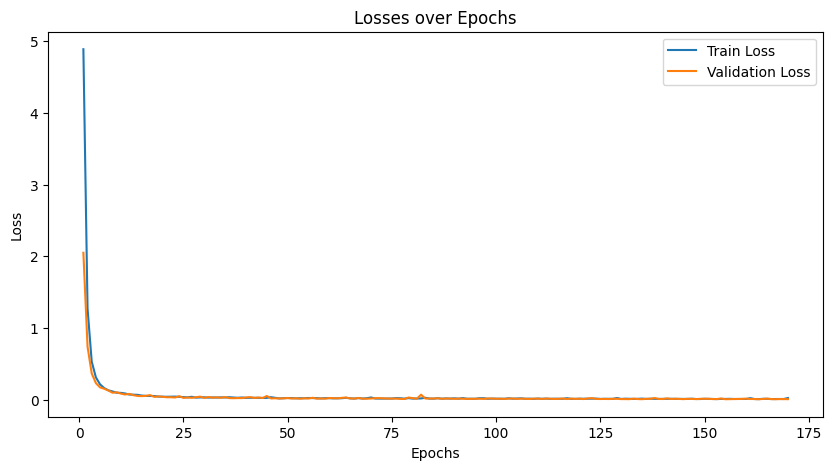

In [26]:
def plot_losses(train_loss, val_loss):
    epochs = np.arange(1, len(train_loss) + 1)
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, train_loss, label='Train Loss')
    plt.plot(epochs, val_loss, label='Validation Loss')
    plt.title('Losses over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


plot_losses(train_losses, val_losses)

In [27]:
model.eval()
with torch.no_grad():
    predictions = model(X_test)

# Rescale predictions back to [0, 73.8]
pred_real = predictions * 73.8

In [33]:
y_test_scaled = y_test * 73.8
pred_real = torch.round(pred_real, decimals=1)
print(pred_real)

tensor([[73.8000, 73.8000, 73.8000,  1.2000,  0.1000, 68.1000],
        [ 0.0000,  0.1000, 58.5000,  0.0000, 48.7000,  0.0000],
        [48.7000, 28.8000,  0.4000, 16.7000, 24.1000, 23.5000],
        ...,
        [73.8000, 73.7000, 73.8000, 54.7000,  0.2000,  0.0000],
        [73.8000, 73.7000, 73.7000,  0.0000, 73.7000, 54.7000],
        [73.6000, 69.5000,  0.2000, 43.2000, 66.0000, 55.7000]])


In [34]:
print(y_test_scaled)

tensor([[73.4300, 73.3600, 73.2900,  0.0000,  0.0000, 69.4700],
        [ 0.0000,  0.0000, 57.5600,  0.0000, 48.9800,  0.0000],
        [49.2700, 28.4200,  0.0000, 16.8800, 24.0200, 23.3700],
        ...,
        [73.8000, 73.7200, 73.8000, 54.3900,  0.0000,  0.0000],
        [73.8000, 73.8000, 73.8000,  0.0000, 73.8000, 54.6100],
        [73.5800, 71.1300,  0.0000, 44.6500, 67.7400, 56.7000]])


In [31]:
# Calculate the mean squared error
mse = nn.MSELoss()
test_loss = mse(pred_real, y_test_scaled).item() 
print(f"Test Loss (MSE): {test_loss}")

Test Loss (MSE): 0.8020479083061218
